# Deconvolution using nideconv

In [1]:
import nideconv
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style="whitegrid", font_scale=1)

import pandas as pd
from lmfit import minimize, Parameters, Parameter, report_fit

import sys
import os
#import fir
import pickle as pkl

import glob
import re

from nilearn import masking, plotting
import nibabel as nib

# many future warnings here, these can be annoying
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
%matplotlib inline 


/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling 

### 1. Extract timeseries per subject/run/session for all ROIs

In [2]:
import pandas as pd
from nilearn import input_data
import nibabel as nb
from nilearn._utils import check_niimg
from nilearn import image
import numpy as np

def extract_timecourse_from_nii(atlas,
                                nii,
                                mask=None,
                                confounds=None,
                                atlas_type=None,
                                t_r=None,
                                low_pass=None,
                                high_pass=1./128,
                                *args,
                                **kwargs):
    """
    Extract time courses from a 4D `nii`, one for each label 
    or map in `atlas`,
    This method extracts a set of time series from a 4D nifti file
    (usually BOLD fMRI), corresponding to the ROIs in `atlas`.
    It also performs some minimal preprocessing using 
    `nilearn.signal.clean`.
    It is especially convenient when using atlases from the
    `nilearn.datasets`-module.
    Parameters
    ----------
    atlas: sklearn.datasets.base.Bunch  
        This Bunch should contain at least a `maps`-attribute
        containing a label (3D) or probabilistic atlas (4D),
        as well as an `label` attribute, with one label for
        every ROI in the atlas.
        The function automatically detects which of the two is
        provided. It extracts a (weighted) time course per ROI.
        In the case of the probabilistic atlas, the voxels are
        weighted by their probability (see also the Mappers in
        nilearn).
    nii: 4D niimg-like object
        This NiftiImage contains the time series that need to
        be extracted using `atlas`
    mask: 3D niimg-like object
        Before time series are extracted, this mask is applied,
        can be useful if you want to exclude non-gray matter.
    confounds: CSV file or array-like, optional
        This parameter is passed to nilearn.signal.clean. Please 
        see the related documentation for details.
        shape: (number of scans, number of confounds)
    atlas_type: str, optional
        Can be 'labels' or 'probabilistic'. A label atlas
        should be 3D and contains one unique number per ROI.
        A Probabilistic atlas contains as many volume as 
        ROIs.
        Usually, `atlas_type` can be detected automatically.
    t_r, float, optional
        Repetition time of `nii`. Can be important for
        temporal filtering.
    low_pass: None or float, optional
        This parameter is passed to signal.clean. Please see the related
        documentation for details
    high_pass: None or float, optional
        This parameter is passed to signal.clean. Please see the related
        documentation for details
    Examples
    --------
    >>> from nilearn import datasets
    >>> data = '/data/ds001/derivatives/fmriprep/sub-01/func/sub-01_task-checkerboard_bold.nii.gz'
    >>> atlas = datasets.fetch_atlas_pauli_2017()
    >>> ts = extract_timecourse_from_nii(atlas,
                                         data,
                                         t_r=1.5)
    >>> ts.head()
    """

    standardize = kwargs.pop('standardize', False)
    detrend = kwargs.pop('detrend', False)

    if atlas_type is None:
        maps = check_niimg(atlas.maps)

        if len(maps.shape) == 3:
            atlas_type = 'labels'
        else:
            atlas_type = 'prob'

    if atlas_type == 'labels':
        masker = input_data.NiftiLabelsMasker(atlas.maps,
                                              mask_img=mask,
                                              standardize=standardize,
                                              detrend=detrend,
                                              t_r=t_r,
                                              low_pass=low_pass,
                                              high_pass=high_pass,
                                              *args, **kwargs)
    else:
        masker = input_data.NiftiMapsMasker(atlas.maps,
                                            mask_img=mask,
                                            standardize=standardize,
                                            detrend=detrend,
                                            t_r=t_r,
                                            low_pass=low_pass,
                                            high_pass=high_pass,
                                            *args, **kwargs)

    # sm: don't make psc
#    data = _make_psc(nii)
    data = nii

    results = masker.fit_transform(data,
                                   confounds=confounds)

    # For weird atlases that have a label for the background
    if len(atlas.labels) == results.shape[1] + 1:
        atlas.labels = atlas.labels[1:]

    if t_r is None:
        t_r = 1

    index = pd.Index(np.arange(0,
                               t_r*data.shape[-1],
                               t_r),
                     name='time')

    columns = pd.Index(atlas.labels,
                       name='roi')

    return pd.DataFrame(results,
                        index=index,
                        columns=columns)


def _make_psc(data):
    mean_img = image.mean_img(data)

    # Replace 0s for numerical reasons
    mean_data = mean_img.get_data()
    mean_data[mean_data == 0] = 1
    denom = image.new_img_like(mean_img, mean_data)

    return image.math_img('data / denom[..., np.newaxis] * 100 - 100', data=data, denom=denom)

In [3]:
def get_event_data(subject_id, session, run, bids_root='./data/deriv/fmriprep', 
                   event_types=('go_trial', 'successful_stop', 'failed_stop'),
                   get_jitters=True, drop_duplicates=True):
    """ Loads all event data """
    import pandas

    if session in ['optcomb', 'me', 'PAID', 'echo_1', 'echo_2', 'echo_3', 'me-den']:
        session = 'me'
    fn = os.path.join(bids_root, 'sub-' + subject_id, 'ses-' + session, 
                      'func', 'sub-{}_ses-{}_task-stop_run-{}_events.tsv'.format(subject_id, session, run))
    df = pandas.read_csv(fn, sep='\t')

    # Since many subjects do not have errors and we want the design matrices to be the same(did I write this??)
    # across subjects, we only look at correct trials
    if event_types is not None:
        to_return = df[np.in1d(df.trial_type, event_types)].fillna(0.1)
    else:
        to_return = df

    if drop_duplicates:
        # drop duplicates (double responses on a single trial)
        to_return = to_return.drop_duplicates('onset')
    return to_return


In [4]:
def get_all_ts(sub, ses, run):
    if ses == 'se':
        dat = pd.read_csv('./deconvolution_cache/sub-{}_ses-se_run-{}_all_ts.tsv'.format(str(sub).zfill(2), run), sep='\t')
    elif ses in ['optcomb', 'PAID']:
        dat = pd.read_csv('./deconvolution_cache/sub-{}_ses-me_run-{}_comb-{}_all_ts.tsv'.format(str(sub).zfill(2), run, ses), sep='\t')
    elif 'echo_' in ses:
        dat = pd.read_csv('./deconvolution_cache/sub-{}_ses-me_run-{}_echo-{}_all_ts.tsv'.format(str(sub).zfill(2), run, ses[-1]), sep='\t')
    elif ses == 'me-den':
        dat = pd.read_csv('./deconvolution_cache/sub-{}_ses-me-den_run-{}_comb-optcomb_all_ts.tsv'.format(str(sub).zfill(2), run), sep='\t')
    return dat
#get_all_ts(1, 'echo_1', 1)

In [5]:
def mp_helper(to_run, atlas_maps, atlas_labels, cache_fn='/home/stevenm/MultiEchoEPISeq/deconvolution_cache', 
              bids_root='/home/stevenm/MultiEchoEPISeq/data/deriv/fmriprep', overwrite=False):
    
    ses, sub, run = to_run
    sub_str = str(sub).zfill(2)
    if sub == 12:
        return 0

    if ses == 'se':
        cache_fn_this_run = os.path.join(cache_fn, 'sub-{}_ses-{}_run-{}_all_ts.tsv'.format(sub_str, ses, run))
        bold_fn = os.path.join(bids_root, 
                               'sub-{}', 
                               'ses-se', 'func',
                               'sub-{}_ses-se_task-stop_run-{}_space-MNI152NLin2009cAsym_desc-preproc-hp_bold.nii.gz').format(sub_str, sub_str, run)
    elif ses in ['optcomb', 'PAID']:
        cache_fn_this_run = os.path.join(cache_fn, 'sub-{}_ses-{}_run-{}_comb-{}_all_ts.tsv'.format(sub_str, 'me', run, ses))
        bold_fn = os.path.join(bids_root, 
                               'sub-{}', 
                               'ses-me',  'func',
                               'sub-{}_ses-me_task-stop_run-{}_space-MNI152NLin2009cAsym_desc-preproc-hp-{}_bold.nii.gz').format(sub_str, sub_str, run, ses)
    elif 'echo' in ses:
        cache_fn_this_run = os.path.join(cache_fn, 'sub-{}_ses-{}_run-{}_echo-{}_all_ts.tsv'.format(sub_str, 'me', run, ses[-1]))
        bold_fn = os.path.join(bids_root, 
                               'sub-{}', 
                               'ses-me',  'func',
                               'sub-{}_ses-me_task-stop_run-{}_echo-{}_space-MNI152NLin2009cAsym_desc-preproc-hp_bold.nii.gz').format(sub_str, sub_str, run, ses[-1])
    elif ses == 'me-den':
        cache_fn_this_run = os.path.join(cache_fn, 'sub-{}_ses-{}_run-{}_comb-optcomb_all_ts.tsv'.format(sub_str, 'me-den', run))
        bold_fn = './lcat_denoising/sub-{}_ses-me_task-stop_run-{}_space-MNI152NLin2009cAsym_desc-preproc-hp-optcomb_bold_lcat-den.nii.gz'.format(sub_str, run)
    
    # hate to do this in this function but the atlas cannot be pickled so required for multiprocess
    class AttrDict(dict):
        def __init__(self, *args, **kwargs):
            super(AttrDict, self).__init__(*args, **kwargs)
            self.__dict__ = self

    atlas = AttrDict({'maps': atlas_maps,
                      'labels': atlas_labels})
    
    if os.path.exists(cache_fn_this_run) and not overwrite:
        ts = pd.read_csv(cache_fn_this_run, sep='\t')
    else:
        print('Sub {}, ses/echo/combination {}, run {}...'.format(sub_str, ses, run))
        ts = extract_timecourse_from_nii(atlas, 
                                         nib.load(bold_fn),
                                         t_r=3,
                                         high_pass=None,
                                         detrend=False)
        ts.to_csv(cache_fn_this_run, sep='\t')
                                         
    return ts

In [6]:
import itertools

subs = np.arange(1, 19)
runs = [1,2,3]
ses = ['me-den']

to_run = list(itertools.product(ses, subs, runs))

from utils import load_atlas
roi_atlas = load_atlas()

In [7]:
# parallel
import multiprocessing as mp
from functools import partial

with mp.Pool(10) as p:
    p.map(partial(mp_helper, atlas_maps=roi_atlas.maps, atlas_labels=[x for x in roi_atlas.labels], overwrite=False), to_run)

### Fit models

In [8]:
def get_session_timeseries(ses, standardize='zscore', override_runs=None):
    dfs = []
    for sub in range(1,19):
        if sub == 12:
            continue
        elif sub == 17:
            runs = [1,2]
        else:
            runs = [1,2,3]
        sub = str(sub).zfill(2)
        
        if override_runs is not None:
            runs = override_runs
            if runs[0] == 3 and sub == 17:
                continue

        for run in runs:
            ts = get_all_ts(sub, ses, run)
            
            # set on common scale across runs
            if standardize == 'psc':
                ts = ts.apply(lambda x: x/np.mean(x) * 100 - 100, axis=0)
            elif standardize == 'zscore':
                ts = ts.apply(lambda x: (x-np.mean(x)) / np.std(x), axis=0)
                
            ts['subject'] = sub
            ts['run'] = run
            ts.drop(labels='time', axis=1, inplace=True)
            dfs.append(ts)
            
    all_dat = pd.concat(dfs)
    all_dat['session'] = ses
    all_dat = all_dat.set_index(['subject', 'session', 'run'])
    return all_dat

def get_all_onsets(ses, event_types=('go_trial', 'failed_stop', 'successful_stop', 'response_left', 'response_right')):
    onset_dfs = []
    for sub in range(1,19):
        if sub == 12:
            continue
        elif sub == 17:
            runs = [1,2]
        else:
            runs = [1,2,3]
        sub = str(sub).zfill(2)

        for run in runs:
            onsets_this_run = get_event_data(sub, ses, run, event_types=event_types)
            onsets_this_run['subject'] = sub
            onsets_this_run['session'] = ses
            onset_dfs.append(onsets_this_run)

    onsets = pd.concat(onset_dfs)
    onsets = onsets.loc[onsets.trial_type.isin(event_types),
                        ['subject', 'session', 'run', 'trial_type', 'onset', 'duration', 'response_time']]
    onsets = onsets.set_index(['subject', 'session', 'run'])
    return onsets

In [9]:
def plot_single_mask_timecourses(rfGroup, data_type,
                                 mask_name, oversample=100, plot_type='first_level',
                                 event_types=('go_trial', 'failed_stop', 'successful_stop'),
                                 ax=None, legend='brief', add_sigma2=False):
    
    if ax is None:
        f, ax = plt.subplots(11)
        
    if data_type == 't':
        ## plot t-values
        if rfGroup.concatenate_runs:
            rfs = rfGroup._get_response_fitters(concatenate_runs=True)
            t_ = rfs.apply(lambda rf: rf.get_t_value_timecourses(oversample))
            t = pd.concat(t_.to_dict())
            index_names = t_.index.names
            t.index.set_names(index_names, level=range(len(index_names)), inplace=True)
            tc_3 = t['t'].reset_index()[['subject', 'event type', 'time', mask_name]]
            
        else:
            tc = rfGroup.get_t_value_timecourses(oversample=oversample, concatenate_runs=rfGroup.concatenate_runs).t
            tc = tc[mask_name].reset_index()

            # mean over runs
            tc_2 = tc.reset_index().rename(columns={"level_0": 'subject', 'level_1': 'session', 'level_2': 'run'})
            tc_3 = tc_2.pivot_table(values=mask_name, index=['subject', 'session', 'event type', 'time']).reset_index()
        sns.lineplot(x='time', y=mask_name, hue='event type', hue_order=event_types, data=tc_3, legend=legend, ax=ax,
                     ci=67)
    elif data_type == 'psc':
        ## plot psc or z-scores
        tc = rfGroup.get_subjectwise_timecourses(oversample=oversample, melt=True)
        
        if plot_type == 'first_level':
            tc = tc.loc[np.in1d(tc['event type'], event_types)]
            
            sns.lineplot(x='time', y='value', hue='event type', hue_order=event_types, 
                         data=tc.loc[tc['roi']==mask_name], 
                         legend=legend, ax=ax, ci=67)
        else:
            tc = tc.loc[tc.roi==mask_name]
            tc = tc.loc[np.in1d(tc['event type'], ('go_trial', 'failed_stop', 'successful_stop'))]
            tc = tc.pivot_table(values='value', index=['subject', 'time', 'covariate'], columns='event type').reset_index()
            tc['failed_stop - go_trial'] = tc['failed_stop'] - tc['go_trial']
            tc['failed_stop - successful_stop'] = tc['failed_stop'] - tc['successful_stop']
            tc['successful_stop - go_trial'] = tc['successful_stop'] - tc['go_trial']
            tc = tc.melt(id_vars=['subject', 'time'], value_vars=['failed_stop - go_trial', 'failed_stop - successful_stop', 'successful_stop - go_trial'])
            sns.lineplot(x='time', y='value', hue='event type', data=tc, legend=legend, ax=ax)

    if add_sigma2:
        sigma2 = rfGroup._get_response_fitters().apply(lambda x: x.sigma2)[mask_name]
        t = ax.text(.95, .95, '$\sigma^2 = {}\pm{}$'.format(np.mean(sigma2).round(2), np.std(sigma2).round(2)),
                     horizontalalignment='right',
                     verticalalignment='top',
                     transform = ax.transAxes)
        t.set_bbox(dict(facecolor='white', alpha=1.0, edgecolor='grey'))
        
    ax.axhline(y=0, c='k', ls='--')
    ax.axvline(x=0, c='k', ls='--')
    
from matplotlib import gridspec
    
def make_plot(plot_dict, data_type, columns, masks, oversample=100, plot_type='first_level', 
              y_label='% signal change', event_types=('failed_stop', 'go_trial', 'successful_stop'),
              column_titles=None, add_sigma2=False, sharey='row', labels=None):
    
    if len(columns) == 5 and not sharey == 'row':
        width_ratios = [1, 0.1, 1, 0.3, 1, .1, 1, .1, 1]
    else:
        width_ratios = [1, .15] * (len(columns)-1) + [1]
    gridspec_kws = dict(hspace=0.1, wspace=0.0, width_ratios=width_ratios)
    f, axes = plt.subplots(len(masks), len(width_ratios), gridspec_kw=gridspec_kws)

    columns_to_populate = np.arange(len(columns), dtype=int)*2
    empty_columns = [x for x in np.arange(len(width_ratios)) if not x in columns_to_populate]
    for col in empty_columns:
        for row in range(len(masks)):
            axes[row, col].axis('off')
    
    if len(axes.shape) == 1:
        axes = axes[np.newaxis,:]

    f.text(0.05, 0.5, y_label, va='center', rotation='vertical')#, labelpad=30)

    # for titles: https://stackoverflow.com/questions/40936729/matplotlib-title-spanning-two-or-any-number-of-subplot-columns
    ext = []
    # loop over the columns (j) and rows(i) to populate subplots
    for j in range(len(axes[0,:])):
        # save the axes bounding boxes for later use
        ext.append([axes[0,j].get_window_extent().x0, axes[0,j].get_window_extent().width])

    # make nice
    inv = f.transFigure.inverted()
    width_left = ext[0][0]+(ext[columns_to_populate.max()][0]+ext[columns_to_populate.max()][1]-ext[0][0])/2.
    left_center = inv.transform( (width_left, 1) )

    # set column spanning title 
    # the first two arguments to figtext are x and y coordinates in the figure system (0 to 1)
    plt.figtext(left_center[0], .1, "Time from trial onset (s)", va="center", ha="center")

    # plot
    for row, mask in enumerate(masks):
        print(mask, end='')
        for col_n, session_name in zip(columns_to_populate, columns):
    
            if isinstance(oversample, list):
                oversample_ = oversample[col_n]
            else:
                oversample_ = oversample
            print('.', end='')
            plot_single_mask_timecourses(plot_dict[session_name],
                                         data_type=data_type,
                                         mask_name=mask, 
                                         ax=axes[row,col_n], 
                                         plot_type=plot_type,
                                         oversample=oversample_,
                                         event_types=event_types,
                                         add_sigma2=add_sigma2)
            if col_n > 0:
                axes[row, col_n].set_ylabel('')
            # remove xlabels except bottom row
#             if row < (len(masks)-1):
            axes[row, col_n].set_xlabel('')
        axes[row,0].set_ylabel(mask)

        if sharey == 'row':
            # get maximum ylims, set
            current_ranges = np.array([np.array(x.get_ylim()) for x in axes[row, columns_to_populate]])
            # increase max ylim by 10% to make some room for sigma**2 annotation
            ylims = np.array([current_ranges.min(0)[0], current_ranges.max(0)[1]])
            ylims[1] = ylims[1]+0.1*(ylims[1]-ylims[0])
            for ax in axes[row, columns_to_populate]:
                ax.set_ylim(ylims[0], ylims[1])
        else:
            for sharey_columns in sharey:
                sharey_columns = [x*2 for x in sharey_columns]
                # get maximum ylims, set
                current_ranges = np.array([np.array(x.get_ylim()) for x in axes[row, sharey_columns]])
                # increase max ylim by 10% to make some room for sigma**2 annotation
                ylims = np.array([current_ranges.min(0)[0], current_ranges.max(0)[1]])
                ylims[1] = ylims[1]+0.1*(ylims[1]-ylims[0])

                for ax in axes[row, sharey_columns]:
                    ax.set_ylim(ylims[0], ylims[1])

    # Add column titles
    if column_titles is None:
        column_titles = columns
    
    for col_n, col_name in zip(columns_to_populate, column_titles):
        axes[0, col_n].set_title(col_name.replace('_', ' '))

    if plot_type == 'contrasts':
        labels = ["Failed stop - go", "Failed stop - successful stop", "Successful stop - go"]
    else:
        if labels is None:
            labels = ['Failed stop', 'Go', 'Successful stop']
        
    # remove legends except first
    for row_n in range(len(masks)):
        for col_n in columns_to_populate:
            if col_n == 4 and row_n == 0:
                leg = axes[row_n, col_n].legend(handles=axes[row_n, col_n].lines, 
                                          labels=labels,
                                          loc=9, ncol=3, bbox_to_anchor=(.5, 1.4))
                for line in leg.get_lines():
                    line.set_linewidth(2.0)
#                 axes[row_n, col_n].legend_.set_bbox_to_anchor((1, 1), transform=axes[row_n, col_n].transAxes)
            else:
                axes[row_n, col_n].legend_.remove()
    
    # determine where to place/remove ticks on y-axis
    if sharey == 'row':
        keep_y_ticks = [0]
    else:
        keep_y_ticks = [x[0]*2 for x in sharey]
        
    # hide ticks/values on axes
    for col in np.arange(1, columns_to_populate.max()+1):
        if col in keep_y_ticks:
            labelleft = 'On'
        else:
            labelleft = 'Off'

        for row in range(0, len(masks)-1):
            axes[row, col].tick_params(top='off', right='off', labelbottom='Off', labelleft=labelleft)

        # for bottom row, keep bottom labels
        axes[len(masks)-1,col].tick_params(top='off', right='off', labelleft=labelleft)

    for row in range(0, len(masks)-1):
#        axes[row, -1].tick_params(top='off', right='off', labelbottom='Off')
        for col in keep_y_ticks:
            axes[row, col].tick_params(top='off', right='off', labelbottom='Off')
    

    f.set_size_inches(len(columns)*4, len(masks)*3)
    return f, axes

## Fit

In [10]:
ses_ts = {'se': {'psc': get_session_timeseries('se', standardize='psc'),
                 'zscore': get_session_timeseries('se', standardize='zscore')},
          'optcomb': {'psc': get_session_timeseries('optcomb', standardize='psc'),
                      'zscore': get_session_timeseries('optcomb', standardize='zscore')},
          'echo_1': {'psc': get_session_timeseries('echo_1', standardize='psc'),
                     'zscore': get_session_timeseries('echo_1', standardize='zscore')},
          'echo_2': {'psc': get_session_timeseries('echo_2', standardize='psc'),
                     'zscore': get_session_timeseries('echo_2', standardize='zscore')},
          'echo_3': {'psc': get_session_timeseries('echo_3', standardize='psc'),
                     'zscore': get_session_timeseries('echo_3', standardize='zscore')}}

In [11]:
rfGroups = {}

for ses in ['se', 'optcomb', 'echo_1', 'echo_2', 'echo_3']:
    print('Data: {}...'.format(ses), end='')
    onsets = get_all_onsets(ses=ses, event_types=('go_trial', 'successful_stop', 'failed_stop'))
    # NB: slice time correction references to TR/2, not to 0; shift onsets to align timesereis and events
    onsets['onset'] -= 1.5
    onsets['rt'] = onsets['response_time'] - onsets['onset'] - 1.5
    onsets = onsets.loc[~((onsets['rt'] > 1) & (onsets['trial_type'] != 'successful_stop'))]
    del onsets['duration']
    del onsets['response_time']
    del onsets['rt']
    
    ts = ses_ts[ses]['psc']

    # deconvolve
    rfGroup = nideconv.GroupResponseFitter(ts, onsets, 1/3.,
                                           oversample_design_matrix=100)
    rfGroup.add_event(interval=[0,18], basis_set='fourier', n_regressors=5)
    rfGroup.fit()

    rfGroups[ses] = rfGroup

rfGroups

Data: se...

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2843: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


Data: optcomb...

Data: echo_1...

Data: echo_2...

Data: echo_3...

{'se': <nideconv.group_analysis.GroupResponseFitter at 0x7f203b3d18d0>,
 'optcomb': <nideconv.group_analysis.GroupResponseFitter at 0x7f2028fb8898>,
 'echo_1': <nideconv.group_analysis.GroupResponseFitter at 0x7f2029004198>,
 'echo_2': <nideconv.group_analysis.GroupResponseFitter at 0x7f2028750eb8>,
 'echo_3': <nideconv.group_analysis.GroupResponseFitter at 0x7f2028750898>}

### Plots
$\beta$-values

In [12]:
plot_masks = ['rM1', 'rPreSMA', 'rIFG', 'rSTR', 'rGPe', 'rGPi', 'rSTN']

rM1.....rPreSMA.....rIFG.....rSTR.....rGPe.....rGPi.....rSTN.....

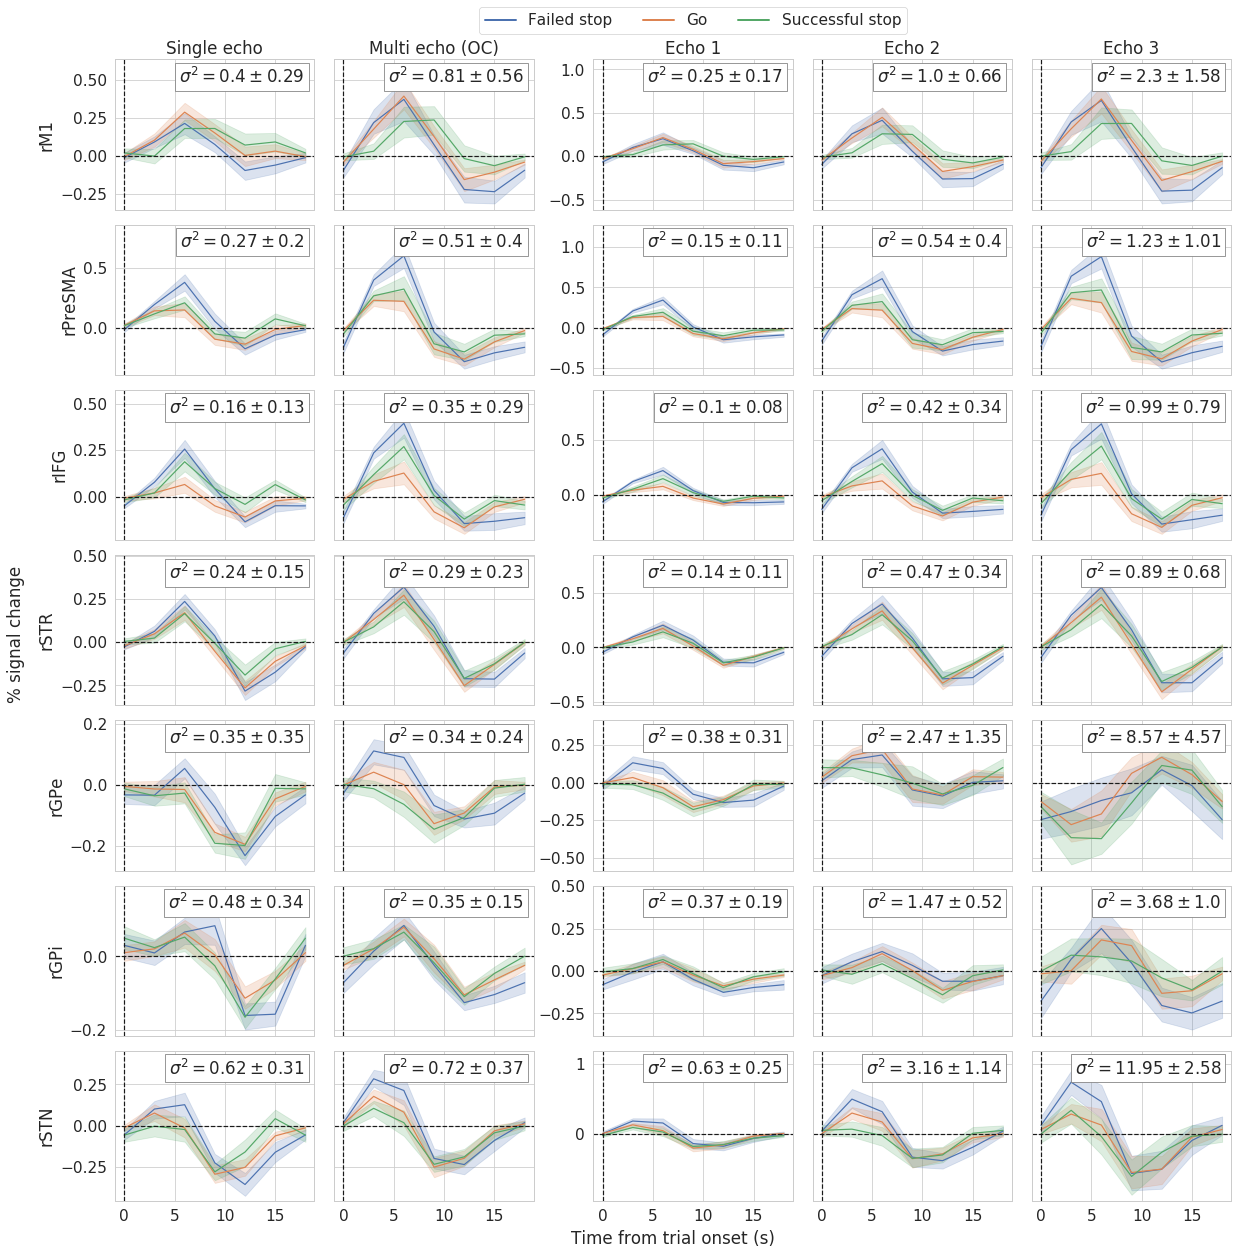

In [13]:
columns = ['se', 'optcomb', 'echo_1', 'echo_2', 'echo_3']
sns.set_context("paper", font_scale=1.75)

f, ax = make_plot(plot_dict=rfGroups,
                  y_label='% signal change',
                  columns=columns, 
                  masks=plot_masks,
                  data_type='psc',
                  oversample=1,
                  plot_type='first_level',
                  column_titles = ['Single echo', 'Multi echo (OC)', 'Echo 1', 'Echo 2', "Echo 3"],
                  add_sigma2=True,
                  sharey=[[0,1], [2,3,4]])

f.savefig('figures/deconvolution.pdf', bbox_inches='tight')

$t$-values

rM1.....rPreSMA.....rIFG.....rSTR.....rGPe.....rGPi.....rSTN.....

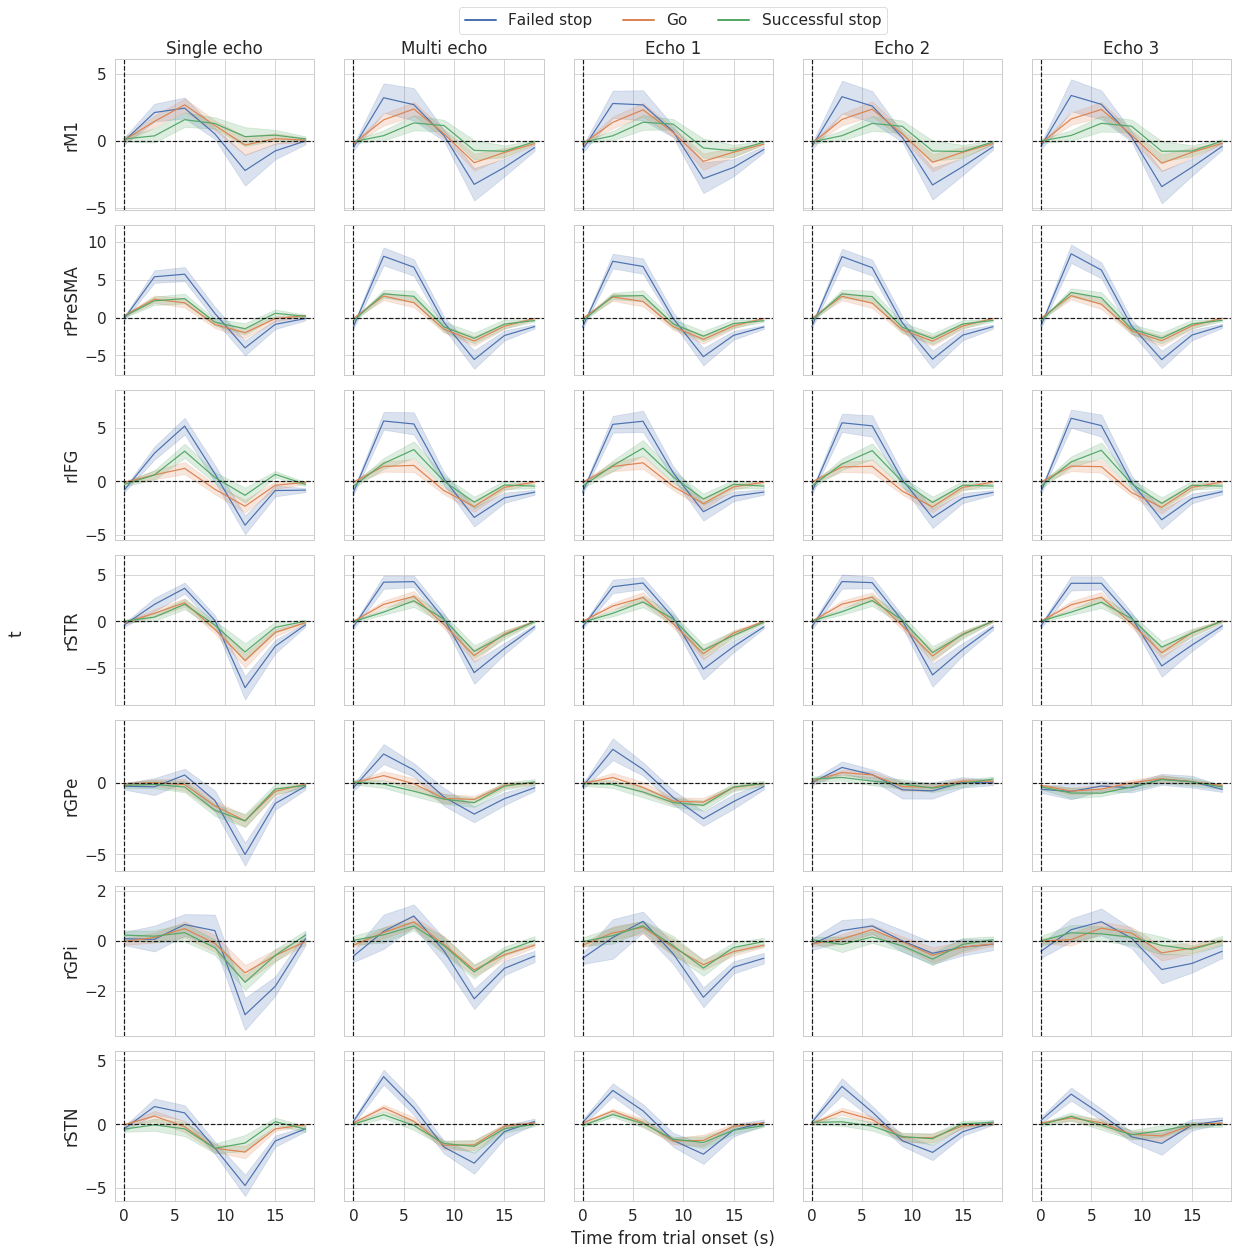

In [14]:
columns = ['se', 'optcomb', 'echo_1', 'echo_2', 'echo_3']

sns.set_context("paper", font_scale=1.75)
f, ax = make_plot(plot_dict=rfGroups,
                  y_label='t',
                  columns=columns, 
                  masks=plot_masks, 
                  data_type='t',
                  oversample=1,
                  plot_type='first_level',
                  column_titles = ['Single echo', 'Multi echo', 'Echo 1', 'Echo 2', "Echo 3"],
                  add_sigma2=False,
                  sharey='row')

rM1..rPreSMA..rIFG..rSTR..rGPe..rGPi..rSTN..

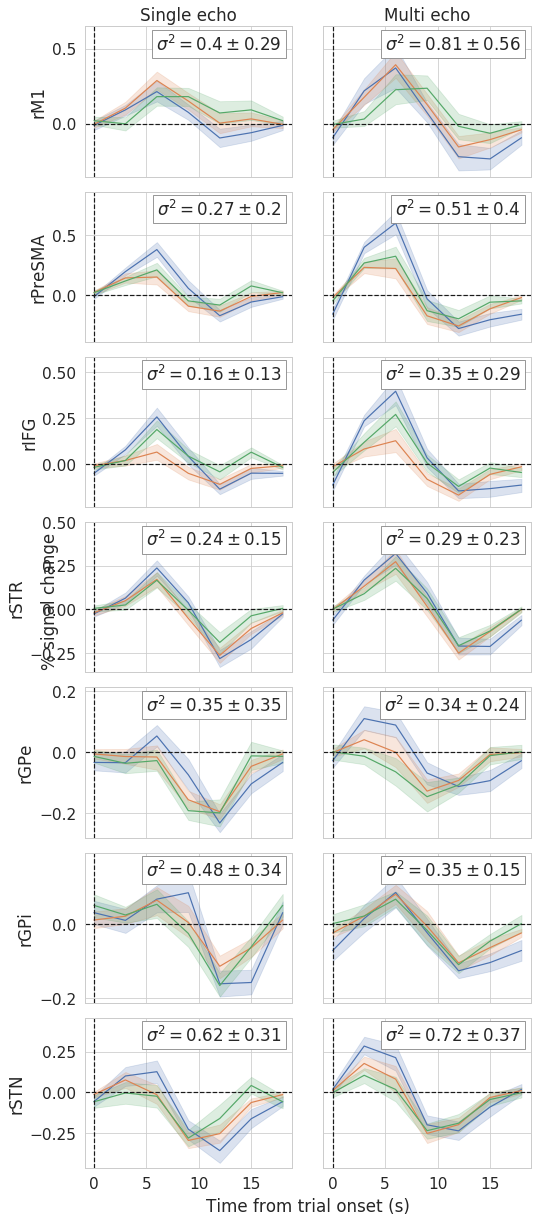

In [15]:
# Zoom in on difference between single echo / multi echo (OC); with PSC
columns = ['se', 'optcomb']

_=  make_plot(plot_dict=rfGroups,
              y_label='% signal change',
              columns=columns, 
              masks=plot_masks, 
              data_type='psc',
              oversample=1,
              plot_type='first_level',
              column_titles=['Single echo', 'Multi echo'],
              add_sigma2=True)

# Slice time correction

Compare slice time corrected vs non-corrected onsets

In [16]:
# Corrected / uncorrected using 5 Fourier basis sets
rfGroupsCor = {}
for ses in ['se', 'optcomb', 'echo_1', 'echo_2', 'echo_3']:
    print('Data: {}...'.format(ses), end='')

    # get relevant data
    ts = ses_ts[ses]['psc']
    onsets = get_all_onsets(ses=ses, event_types=('go_trial', 'successful_stop', 'failed_stop'))
    # NB: slice time correction references to TR/2, not to 0; shift onsets to align timesereis and events
    onsets['onset'] -= 1.5

    # deconvolve
    rfGroup = nideconv.GroupResponseFitter(ts, onsets, 1/3.,
                                           oversample_design_matrix=100)
    rfGroup.add_event(interval=[0,18], basis_set='fourier', n_regressors=5)
    rfGroup.fit()

    rfGroupsCor[ses] = rfGroup

rfGroupsUnc = {}
for ses in ['se', 'optcomb', 'echo_1', 'echo_2', 'echo_3']:
    print('Data: {}...'.format(ses), end='')

    ts = ses_ts[ses]['psc']
    onsets = get_all_onsets(ses=ses, event_types=('go_trial', 'successful_stop', 'failed_stop'))

    # No onsets adjustment for slice time correction!

    # deconvolve
    rfGroup = nideconv.GroupResponseFitter(ts, onsets, 1/3.,
                                           oversample_design_matrix=100)
    rfGroup.add_event(interval=[0,18], basis_set='fourier', n_regressors=5)
    rfGroup.fit()

    rfGroupsUnc[ses] = rfGroup

rfGroupsUnc

Data: se...

Data: optcomb...

Data: echo_1...

Data: echo_2...

Data: echo_3...

Data: se...

Data: optcomb...

Data: echo_1...

Data: echo_2...

Data: echo_3...

{'se': <nideconv.group_analysis.GroupResponseFitter at 0x7f200c084e80>,
 'optcomb': <nideconv.group_analysis.GroupResponseFitter at 0x7f200c82c0f0>,
 'echo_1': <nideconv.group_analysis.GroupResponseFitter at 0x7f2007bcf898>,
 'echo_2': <nideconv.group_analysis.GroupResponseFitter at 0x7f20077ecf60>,
 'echo_3': <nideconv.group_analysis.GroupResponseFitter at 0x7f20073f0160>}

In [17]:
# Corrected / uncorrected using canonical HRF
rfGroupsCorH = {}
for ses in ['se']:
    print('Data: {}...'.format(ses), end='')

    ts = ses_ts[ses]['psc']
    onsets = get_all_onsets(ses=ses, event_types=('go_trial', 'successful_stop', 'failed_stop'))
    # NB: slice time correction references to TR/2, not to 0; shift onsets to align timesereis and events
    onsets['onset'] -= 1.5

    # deconvolve
    rfGroup = nideconv.GroupResponseFitter(ts, onsets, 1/3.,
                                           oversample_design_matrix=100)
    rfGroup.add_event(interval=[0,18], basis_set='canonical_hrf')
    rfGroup.fit()

    rfGroupsCorH[ses] = rfGroup

        
rfGroupsUncH = {}
for ses in ['se']:
    print('Data: {}...'.format(ses), end='')

    ts = ses_ts[ses]['psc']
    onsets = get_all_onsets(ses=ses, event_types=('go_trial', 'successful_stop', 'failed_stop'))

    # No slice time correction-correction in data!

    # deconvolve
    rfGroup = nideconv.GroupResponseFitter(ts, onsets, 1/3.,
                                           oversample_design_matrix=100, concatenate_runs=False)
    rfGroup.add_event(interval=[0,18], basis_set='canonical_hrf')
    rfGroup.fit()

    rfGroupsUncH[ses] = rfGroup

rfGroupsUncH

Data: se...

Data: se...

{'se': <nideconv.group_analysis.GroupResponseFitter at 0x7f2006c1ee80>}

In [18]:
# combine dict
plot_dict = {'Corrected, Canonical': rfGroupsCorH['se'],
             'Uncorrected, Canonical': rfGroupsUncH['se'],
             'Corrected, Fourier': rfGroupsCor['se'],
             'Uncorrected, Fourier': rfGroupsUnc['se'],
             }

rSTN....rIFG....

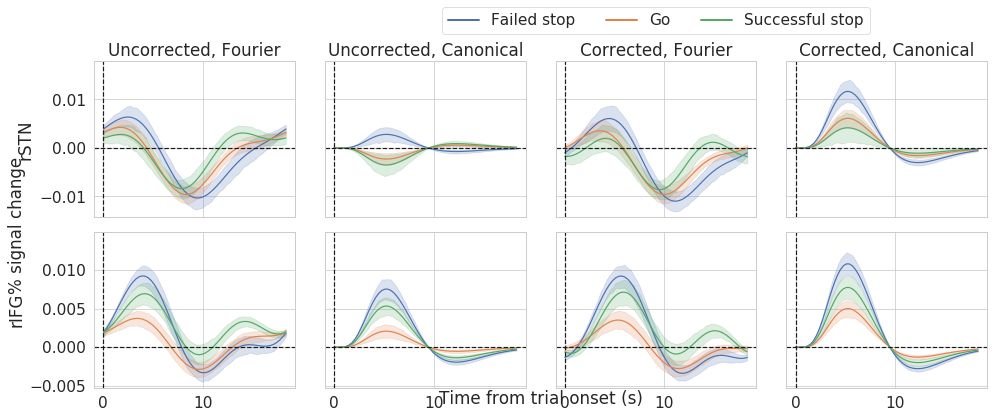

In [19]:
columns = ['Uncorrected, Fourier',
           'Uncorrected, Canonical',
           'Corrected, Fourier',
           'Corrected, Canonical']

_ = make_plot(plot_dict=plot_dict,
              y_label='% signal change',
              columns=columns, 
              masks=['rSTN', 'rIFG'], 
              data_type='psc',
              oversample=[10, 1, 10, 10, 10, 10, 10, 10],
              plot_type='first_level')
plt.gcf().savefig('figures/deconvolution-slicetimecorrection.pdf')

## Canonical HRF with temporal derivative
Fit GLM with canonical HRF + temporal derivative as basis function
Include motion parameters as confounding variables in design matrix

In [20]:
def get_confounds_timeseries(ses, standardize='psc', override_runs=None):
    dfs = []
    for sub in range(1,19):
        if sub == 12:
            continue
        elif sub == 17:
            runs = [1,2]
        else:
            runs = [1,2,3]
        sub_str = str(sub).zfill(2)
        
        if override_runs is not None:
            runs = override_runs
            if runs[0] == 3 and sub == 17:
                continue

        for run in runs:
            if ses == 'se':
                ts = pd.read_csv('./data/deriv/fmriprep/sub-{}/ses-se/func/sub-{}_ses-se_task-stop_run-{}_desc-confounds_regressors.tsv'.format(sub_str, sub_str, run), sep='\t')
            elif ses == 'optcomb':
                ts = pd.read_csv('./data/deriv/fmriprep/sub-{}/ses-me/func/sub-{}_ses-me_task-stop_run-{}_echo-1_desc-confounds_regressors.tsv'.format(sub_str, sub_str, run), sep='\t')
            elif 'echo' in ses:
                echo_n = ses[-1]
                ts = pd.read_csv('./data/deriv/fmriprep/sub-{}/ses-me/func/sub-{}_ses-me_task-stop_run-{}_echo-{}_desc-confounds_regressors.tsv'.format(sub_str, sub_str, run, echo_n), sep='\t')
                                
            ts['subject'] = sub_str
            ts['run'] = run
            if 'time' in ts.columns:
                ts.drop(labels='time', axis=1, inplace=True)
            dfs.append(ts)
            
    all_dat = pd.concat(dfs)
    all_dat['session'] = ses
    all_dat = all_dat.set_index(['subject', 'session', 'run'])
    return all_dat

In [21]:
##
rfGroupsCwD = {}
for ses in ['se', 'optcomb', 'echo_1', 'echo_2', 'echo_3']:
    print('Data: {}...'.format(ses), end='')
    onsets = get_all_onsets(ses=ses, event_types=('go_trial', 'successful_stop', 'failed_stop'))
    # NB: slice time correction references to TR/2, not to 0; shift onsets to align timesereis and events
    onsets['onset'] -= 1.5
    
    # exclude trials with RT > 1
    onsets['rt'] = onsets['response_time'] - onsets['onset'] - 1.5
    onsets = onsets.loc[~((onsets['rt'] > 1) & (onsets['trial_type'] != 'successful_stop'))]
    del onsets['duration']
    del onsets['response_time']
    del onsets['rt']

    # get relevant data
    ts = ses_ts[ses]['psc']
    confounds = get_confounds_timeseries(ses)[['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'framewise_displacement']]
    confounds = confounds.reset_index()

    # deconvolve
    rfGroup = nideconv.GroupResponseFitter(ts, onsets, 1/3., confounds=confounds,
                                           oversample_design_matrix=20)
    rfGroup.add_event(interval=[0,18], basis_set='canonical_hrf_with_time_derivative', type='ar(1)')
    rfGroup.fit(store_residuals=True)

    rfGroupsCwD[ses] = rfGroup

Data: se...

Data: optcomb...

Data: echo_1...

Data: echo_2...

Data: echo_3...

rM1.....rPreSMA.....rIFG.....rSTR.....rGPe.....rGPi.....rSTN.....

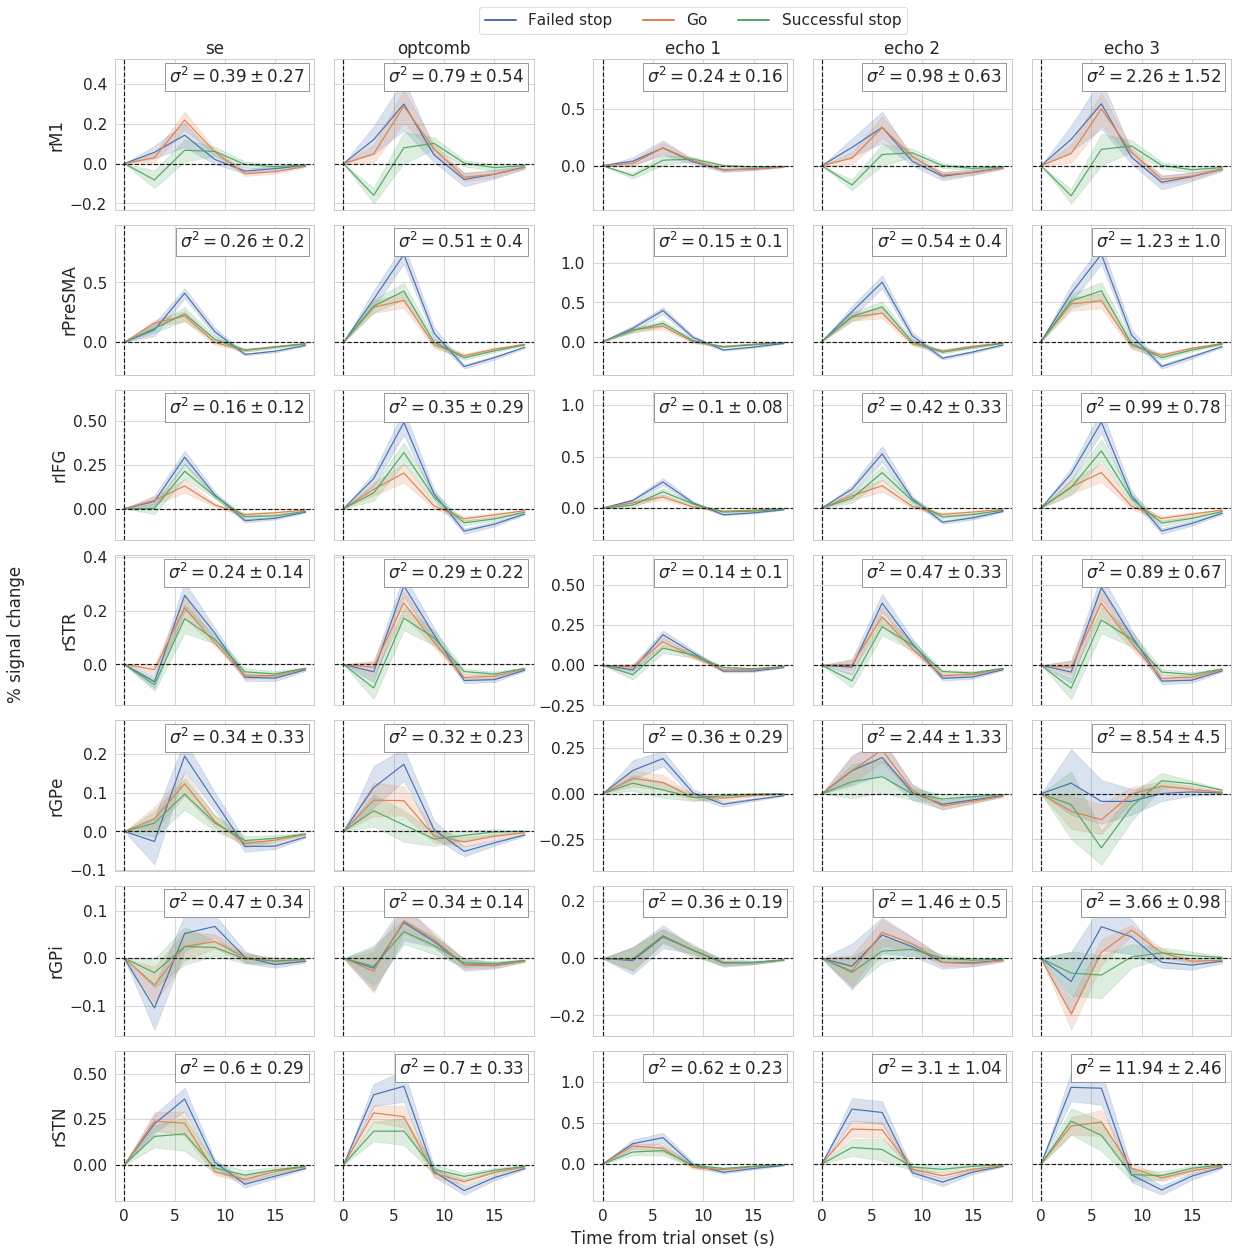

In [22]:
columns = ['se', 'optcomb', 'echo_1', 'echo_2', 'echo_3']

f, ax = make_plot(plot_dict=rfGroupsCwD,
                  y_label='% signal change',
                  columns=columns, 
                  masks=plot_masks, 
                  data_type='psc', 
                  oversample=1,
                  plot_type='first_level',
                  add_sigma2=True,
                  sharey=[(0, 1), (2, 3, 4)])

### Sanity check: What does M1 do (left & right) with responses?

In [23]:
rfGroups_motor_response = {}
evs = ('response_left', 'response_right')

for ses in ['se', 'optcomb', 'echo_1', 'echo_2', 'echo_3']:
    print('Data: {}...'.format(ses), end='')

    # get relevant data
    ts = ses_ts[ses]['psc']
    onsets = get_all_onsets(ses=ses, event_types=evs)
    onsets['onset'] -= 1.5

    # deconvolve
    rfGroup = nideconv.GroupResponseFitter(ts, onsets, 1/3., 
                                           oversample_design_matrix=100, event=evs)
    rfGroup.add_event(interval=[0,18], basis_set='fourier', n_regressors=5)
    rfGroup.fit(type='ar(1)')

    rfGroups_motor_response[ses] = rfGroup

rfGroups_motor_response

Data: se...

Data: optcomb...

Data: echo_1...

Data: echo_2...

Data: echo_3...

{'se': <nideconv.group_analysis.GroupResponseFitter at 0x7f2005efd588>,
 'optcomb': <nideconv.group_analysis.GroupResponseFitter at 0x7f200412b470>,
 'echo_1': <nideconv.group_analysis.GroupResponseFitter at 0x7f2008967208>,
 'echo_2': <nideconv.group_analysis.GroupResponseFitter at 0x7f20084cd7b8>,
 'echo_3': <nideconv.group_analysis.GroupResponseFitter at 0x7f2008e50630>}

$t$-values of motor areas timecourses after motor response

rPreSMA.....lM1.....rM1.....rIFG.....

(<Figure size 1440x864 with 36 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f20041a15c0>,
       dtype=object))

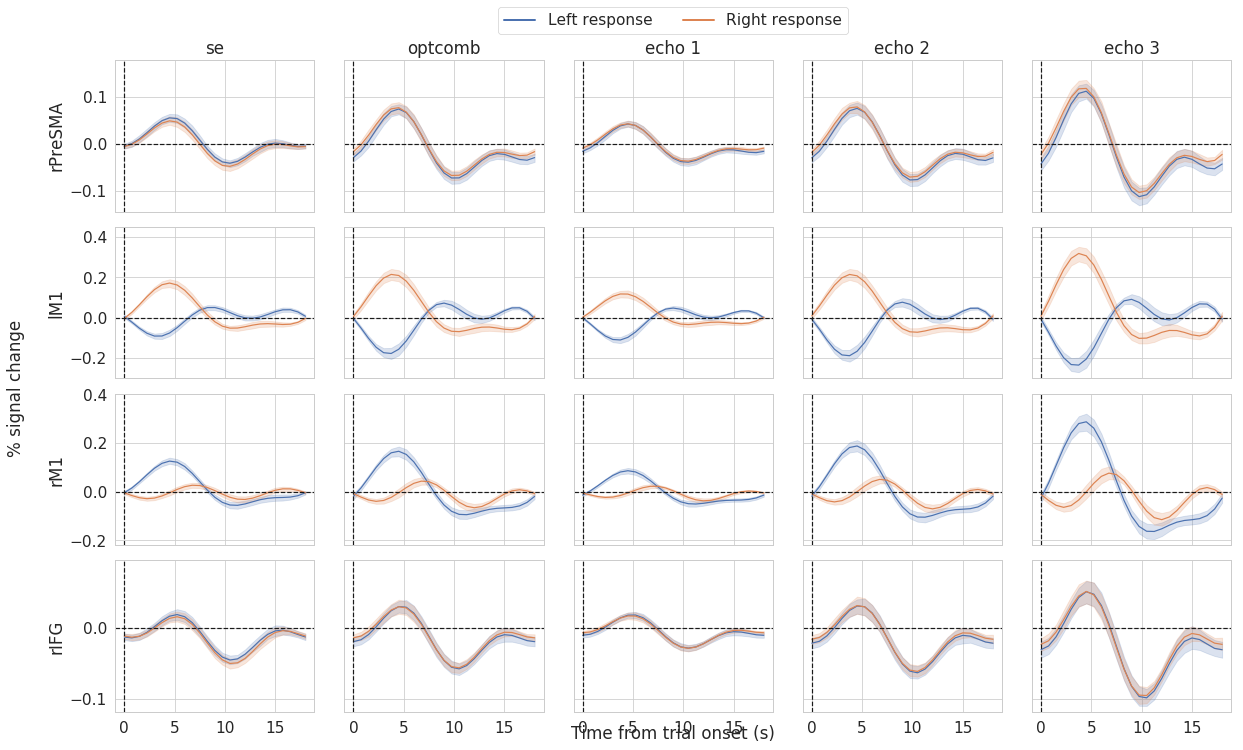

In [24]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=UserWarning)

columns = ['se', 'optcomb', 'echo_1', 'echo_2', 'echo_3']
masks_motor = ['rPreSMA', 'lM1', 'rM1', 'rIFG']

make_plot(rfGroups_motor_response, 
          y_label='% signal change',
          columns=columns, 
          masks=masks_motor, 
          data_type='psc', 
          oversample=4,
          plot_type='first_level',
          labels=['Left response', 'Right response'],
          event_types=evs)